In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


# Importando tabelas e gerando listas

In [2]:
df_dados = pd.read_excel('dados.xlsx')
df_fator = pd.read_excel('config.xlsx', 0)
df_email = pd.read_excel('config.xlsx', 1)

lst_meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
lst_meses_dados = ['Dez anterior','Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov']
lst_layout = ['Galpões', 'Complemento','Registro', 'Empresa', 'Tipo de imóvel']
lst_df_empresas = []


# Gerando Data Frame das diferenças

In [3]:
df_diferença = df_dados.loc[:, lst_layout]

for m, d in zip(lst_meses, lst_meses_dados):
    dif = df_dados.loc[:, m] - df_dados.loc[:, d]
    df_diferença.loc[:, m] = dif


df_diferença = df_diferença.loc[~df_diferença['Jan'].isna(), :].reset_index(drop=True)

df_fator.loc[3, 'Volume max de água m3'] = 999999


# Definição de funções

In [4]:
# criação de função DataFrame para adição de row TOTAL
def DF_total(df):
    num_index = max(df.index) + 1
    df.loc[num_index,:] = df.sum(numeric_only=True, axis=0)
    df.loc[num_index, 'Galpões'] = 'TOTAL'
    df.loc[df['Galpões'] == 'TOTAL', :].round(2)


# criação de função DataFrame para cada empresa. Obs: a variavel ainda será definida antes do uso
def DF_droper_empresa(df, comp):
    df_temp = df.loc[df['Empresa'] == comp, :].reset_index(drop=True)
    # df_temp = df.loc[df['Empresa'] == comp, ['Galpões','Complemento','Registro']+lst_meses_uteis].reset_index(drop=True)
    # df_temp = df_temp.dropna(how='all', axis=1)
    return df_temp


# criando função de adição de linhas vazias
def DF_empty_rows_comb(df):
    
    dc_empty = {col: [np.nan for _ in range(1)] for col in df.columns}
    df_empty = pd.DataFrame(dc_empty)
    df_new = pd.concat([df_empty, df, df_empty], axis=0, ignore_index=True)
    return df_new


# Retirando Colunas inutilizadas

In [5]:
# retirando colunas de meses não marcados para consumo de água
df_diferença = df_diferença.dropna(how='all', axis=1).round(2)


# retirando colunas de meses não marcados para leitura do hidrômetro
df_dados = df_dados.dropna(how='all', axis=1).round(2)

# lista com meses completos
lst_meses_uteis = df_diferença.columns.tolist()
for i in ['Galpões', 'Complemento', 'Registro', 'Empresa', 'Tipo de imóvel']:
    lst_meses_uteis.remove(i)


# Gerando Data Frame dos preços

In [6]:
# retirando informações de poço 
df_preço = df_diferença.loc[df_diferença['Galpões'] != 'Poço', lst_layout]


# calculando e multiplicando o fator para cada diferença. O loop m: meses ; loop type: tipo de imóvel ; loop index: para cada intervalo multiplicador
for m in lst_meses_uteis:
    
    for type in ['Industrial', 'Residencial']:
        df_preço.loc[(df_diferença[m] < df_fator.loc[0,'Volume max de água m3']) & (df_diferença['Tipo de imóvel'] == type), m] = df_fator.loc[0, f'Fator {type}']
        
        for index in range(1, 4):
            df_preço_temp = df_diferença.loc[(df_diferença[m] < df_fator.loc[index,'Volume max de água m3']) & (df_diferença['Tipo de imóvel'] == type) & (df_diferença[m] >= df_fator.loc[index, 'Volume min de água m3']), m]  
            df_preço.loc[(df_diferença[m] < df_fator.loc[index,'Volume max de água m3']) & (df_diferença['Tipo de imóvel'] == type) & (df_diferença[m] >= df_fator.loc[index, 'Volume min de água m3']), m] = df_preço_temp * df_fator.loc[index, f'Fator {type}']


# retirando colunas de meses não marcados
df_preço = df_preço.dropna(how='all', axis=1)

# TOTAL
DF_total(df_preço)
df_preço = df_preço.round(2)


# Formatação e geração de arquivo Tabela.xlsx

In [7]:
# formatação R$ em um novo DataFrame
df_preço_formatado = df_preço.loc[:,:]
df_preço_formatado[lst_meses_uteis] = df_preço_formatado[lst_meses_uteis].map(lambda x: f'R$ {x}')

# formatação m3 em um novo DataFrame
df_diferença_formatado = df_diferença.loc[:,:]
df_diferença_formatado = df_diferença_formatado.round(2)
df_diferença_formatado[lst_meses_uteis] = df_diferença_formatado[lst_meses_uteis].map(lambda x: f'{x} m³')

# criação de arquivo excel
with pd.ExcelWriter("Tabela.xlsx", engine="openpyxl") as writer:
    df_preço_formatado.to_excel(writer, sheet_name="Custo água", index=False)

# criação de arquivo excel
with pd.ExcelWriter("Tabela.xlsx", engine="openpyxl", mode="a") as writer:
    df_diferença_formatado.to_excel(writer, sheet_name="Consumo água", index=False)
    

# Separando arquivos na pasta compartilhamento por empresa

In [8]:
# if not os.path.exists(r'compartilhamento'):
#     os.mkdir(r'compartilhamento')


# lista de empresas
lst_empresa = df_preço['Empresa'].value_counts().index.tolist()


for comp in lst_empresa:

    # criação de DataFrame do custo $ para cada empresa
    # criação de DataFrame do consumo m3 para cada empresa
    # criação de DataFrame do registro para cada empresa
    df_preço_temp = DF_droper_empresa(df_preço, comp)
    df_diferença_temp = DF_droper_empresa(df_diferença, comp)
    df_dados_temp = DF_droper_empresa(df_dados, comp)

    # implementação de TOTAL para custo $
    # implementação de TOTAL para consumo m3
    DF_total(df_preço_temp)
    DF_total(df_diferença_temp)
    
    # formatação de R$
    # formatação de m3
    df_preço_temp[lst_meses_uteis] = df_preço_temp[lst_meses_uteis].map(lambda x: f'R$ {round(x, 2)}')
    df_diferença_temp[lst_meses_uteis] = df_diferença_temp[lst_meses_uteis].map(lambda x: f'{x:.1f} m³')

    

    # empty rows
    df_dados_temp = DF_empty_rows_comb(df_dados_temp)
    df_diferença_temp = DF_empty_rows_comb(df_diferença_temp)
    df_preço_temp = DF_empty_rows_comb(df_preço_temp)
    # informações de cada tabela
    df_dados_temp.loc[0,'Galpões'] = 'LEITURA'
    df_preço_temp.loc[0,'Galpões'] = 'CUSTO'
    df_diferença_temp.loc[0,'Galpões'] = 'CONSUMO '
    
    
    # combinando DataFrames
    df_final_formatado_temp = pd.concat([df_dados_temp, df_diferença_temp, df_preço_temp], axis=0, ).reset_index(drop=True).dropna(how='all', axis=1)
    
    df_final_formatado_temp = df_final_formatado_temp.drop(max(df_final_formatado_temp.index) ,axis=0)
    
    # geração de arquivo excel
    # df_final_formatado_temp.to_excel(fr'compartilhamento\{comp}.xlsx', index=False)

    df_final_formatado_temp = df_final_formatado_temp.fillna('')
    
    # adicionando DataFrames para uma lista
    lst_df_empresas.append(df_final_formatado_temp)
    

# Gerando gráficos internos 
(Consumo de água x mês)

In [9]:
# # Gerando figura com gráficos da diferença 
# fig_int = plt.figure(figsize=(30,80))
# fig_int.suptitle('Gráficos consumo por mês de cada galpão/ casa/ poço')




# Gerando gráficos individuais com tabelas em pdf para cada empresa

# Importando bibliotecas

In [10]:
from reportlab.lib.pagesizes import landscape, A4, A3
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Image, Spacer
from reportlab.lib import colors
from reportlab.lib.units import inch
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import Paragraph
from reportlab.pdfgen import canvas
import io

if not os.path.exists(r'compartilhamento pdf'):
    os.mkdir(r'compartilhamento pdf')

In [11]:
class FooterDocTemplate(SimpleDocTemplate):
    def __init__(self, *args, **kwargs):
        self.footer_text = kwargs.pop('footer_text', '')
        SimpleDocTemplate.__init__(self, *args, **kwargs)
    
    def afterFlowable(self, flowable):
        if self.canv.getPageNumber() == 1:
            self._draw_footer()
    
    def _draw_footer(self):
        self.canv.saveState()
        self.canv.setFont('Helvetica', 15)
        width, height = self.pagesize
        self.canv.drawString(inch, 0.5 * inch, self.footer_text)
        self.canv.restoreState()

<Figure size 640x480 with 0 Axes>

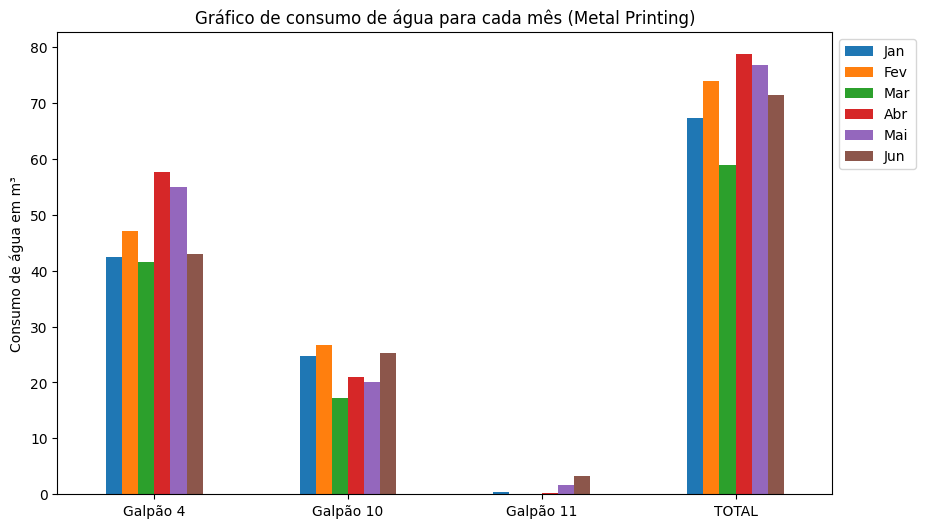

<Figure size 640x480 with 0 Axes>

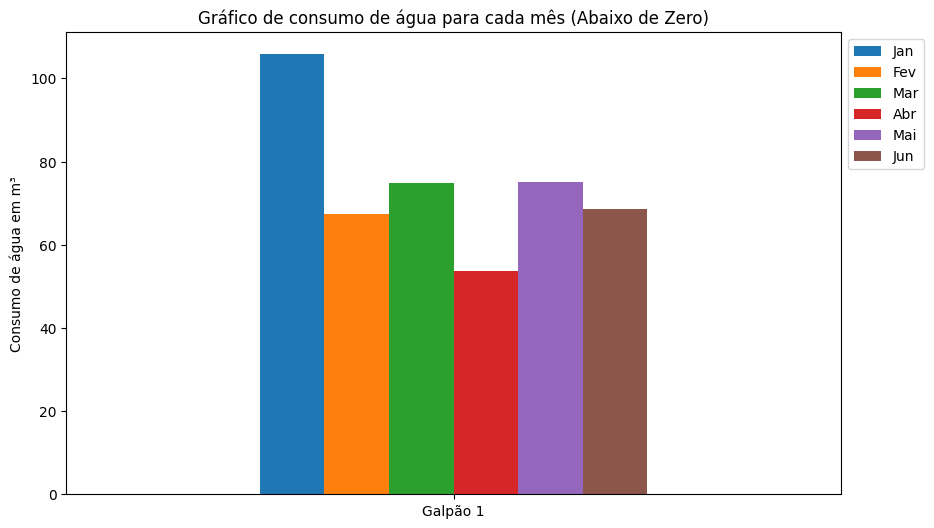

<Figure size 640x480 with 0 Axes>

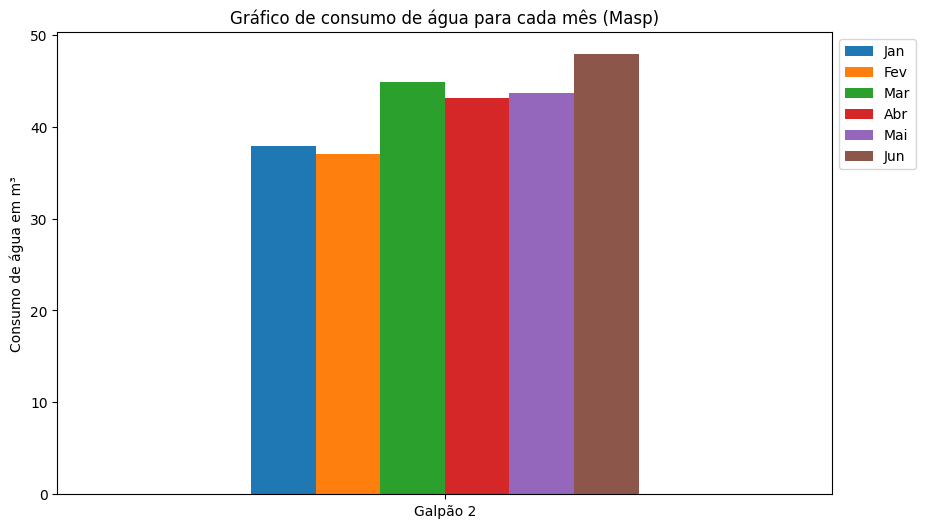

<Figure size 640x480 with 0 Axes>

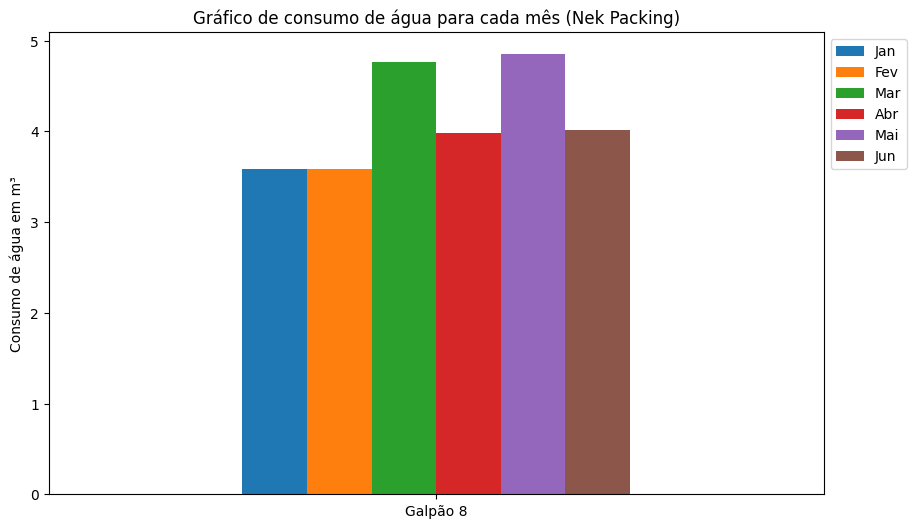

In [12]:
for df, comp in zip(lst_df_empresas, lst_empresa):
    
    # DataFrame importante
    df_para_grafico = DF_droper_empresa(df_diferença, comp)
    df_para_grafico = df_para_grafico.drop(['Registro', 'Complemento', 'Empresa', 'Tipo de imóvel'], axis=1)

    # Empresas que possuem mais de um galpão visualizarão somente o gráfico total
    if max(df_para_grafico.index) > 0:
        DF_total(df_para_grafico)
        # df_para_grafico = df_para_grafico.loc[df_para_grafico['Galpões'] == 'TOTAL', :]
        
        
    df_para_grafico.index = df_para_grafico.loc[:, 'Galpões'].tolist()
    
    df = df.drop(['Tipo de imóvel', 'Empresa'], axis=1)

    
    # Step 2: Create a graph using Matplotlib
    plt.figure()
    df_para_grafico.plot(kind='bar')
    plt.title(f'Gráfico de consumo de água para cada mês ({comp})')
    plt.ylabel('Consumo de água em m³')
    plt.xticks(rotation=0)

    # Place the legend outside the plot area
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    fig = plt.gcf()
    fig.set_size_inches(10, 6)

    # Save the graph to a BytesIO object
    graph_buffer = io.BytesIO()
    plt.savefig(graph_buffer, format='png', dpi=500)
    graph_buffer.seek(0)
    
    # Step 3: Convert the DataFrame to a table that can be added to the PDF
    data_for_pdf = [df.columns.values.tolist()] + df.values.tolist()

    # Step 4: Create a PDF document
    pdf_buffer = io.BytesIO()
    footer_text = f'Arquivo gerado em: {datetime.now().strftime("%d-%m-%Y %H:%M")}'
    pdf = FooterDocTemplate(
        pdf_buffer, 
        pagesize=landscape(A3),
        leftMargin=0.2 * inch,
        rightMargin=0.2 * inch,
        topMargin=0.2 * inch,
        bottomMargin=0.2 * inch,
        footer_text=footer_text
    )

    elements = []

    # Create the table
    table = Table(data_for_pdf, colWidths=[1.0 * inch] * len(df.columns))
    table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
        ('GRID', (0, 0), (-1, -1), 1, colors.black),
    ]))
    elements.append(table)

    # Add a spacer for better spacing between table and graph
    elements.append(Spacer(1, 0.5 * inch))  # Adjust the space as needed

    # Add the graph image to the PDF
    graph_image = Image(graph_buffer)
    graph_image.drawHeight = 6 * inch
    graph_image.drawWidth = 15 * inch
    elements.append(graph_image)

    

    # Build the PDF
    pdf.build(elements)
    pdf_buffer.seek(0)

    # Save the PDF to a file
    with open(f'compartilhamento pdf\{comp}.pdf', 'wb') as f:
        f.write(pdf_buffer.read())




# Enviar emails

In [13]:
import smtplib
import email.message
import email
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
from datetime import datetime

In [14]:
# email e senha para enviar
email_wv = df_email.loc[0, 'email empresa']
password = df_email.loc[0, 'senha']
print(f'\nemail_wv\t{email_wv}, \npassword\t{password}')

# lista de informações sobre as Empresas
lst_email_empresa = df_email.loc[:, 'Empresa destinatária'].dropna().tolist()
lst_email_destinatario = df_email.loc[:, 'Destinatário'].dropna().tolist()
lst_email_email_empresa = df_email.loc[:, 'email empresa'].tolist()
del lst_email_email_empresa[0]
print(f'\nlista empresas: {lst_email_empresa}, \nlista nomes: {lst_email_destinatario}, \nlista emails: {lst_email_email_empresa}')

# lista para retorno
lst_email_email_retorno = df_email.loc[:, 'emails de retorno'].dropna().tolist()




    


email_wv	ggsv22006@gmail.com, 
password	cwiq ygoo exko zbov

lista empresas: ['Abaixo de Zero', 'Masp', 'Metal Printing', 'Nek Packing'], 
lista nomes: ['mr. AZ', 'mr. M', 'mr. MP', 'mr. NP'], 
lista emails: ['ggsv2006@gmail.com', 'ggsv2006@gmail.com', 'ggsv2006@gmail.com', 'ggsv2006@gmail.com']


In [15]:
# for nome, ecomp in zip(lst_email_destinatario, lst_email_email_empresa): 
    
#     lst_temp = []
#     lst_temp.append(ecomp)
#     lst_temp += lst_email_email_retorno

#     corpo_email = f"""
#     <p>Boa tarde {nome}, tudo bem?</p>
#     <p>Segue relatório em anexo.</p>
#     <p>Qualquer dúvida, estou à disposição</p>
#     <p><b>Favor confirmar o recebimento.</b></p>
#     """
#     data_envio = datetime.now().strftime("%m-%Y")
#     msg = MIMEMultipart()
#     msg['Subject'] = f"Relatório Consumo Água {data_envio}"
#     msg['From'] = email_wv
#     msg['To'] = ecomp
#     password = password
#     msg.attach(MIMEText(corpo_email, 'html'))
#     msg.add_header('Content-Type', 'text/html')
#     msg.set_payload(corpo_email)

#     s = smtplib.SMTP('smtp.gmail.com: 587')
#     s.starttls()
#     # Login Credentials for sending the mail
#     s.login(msg['From'], password)
#     s.sendmail(msg['From'], [msg['To']], msg.as_string().encode('utf-8'))
    

In [16]:
for comp, nome, ecomp in zip(lst_email_empresa, lst_email_destinatario, lst_email_email_empresa):
    lst_temp = [ecomp] + lst_email_email_retorno

    corpo_email = f"""
    <p>Boa tarde {nome}, tudo bem?</p>
    <p>Segue relatório em anexo.</p>
    <p>Qualquer dúvida, estou à disposição</p>
    <p><b>Favor confirmar o recebimento.</b></p>
    """
    data_envio = datetime.now().strftime("%m-%Y")

    # Create the email message
    msg = MIMEMultipart()
    msg['Subject'] = f"Relatório Consumo Água {data_envio}"
    msg['From'] = email_wv
    msg['To'] = ', '.join(lst_temp)
    msg.attach(MIMEText(corpo_email, 'html', 'utf-8'))

    # Attach the file
    with open(f'compartilhamento pdf\{comp}.pdf', "rb") as attachment:
        part = MIMEBase("application", "octet-stream")
        part.set_payload(attachment.read())
        encoders.encode_base64(part)
        part.add_header(
            "Content-Disposition",
            f"attachment; filename= compartilhamento pdf\{comp}.pdf",
        )
        msg.attach(part)

    # Connect to the SMTP server and send the email
    try:
        s = smtplib.SMTP('smtp.gmail.com', 587)
        s.starttls()
        s.login(email_wv, password)
        s.sendmail(email_wv, lst_temp, msg.as_string())
        print(f"Email enviado com sucesso para {comp}")
    except Exception as e:
        print(f"Error: {e}")
    finally:
        s.quit()

Error: 'ascii' codec can't encode character '\xa0' in position 25: ordinal not in range(128)
Error: 'ascii' codec can't encode character '\xa0' in position 25: ordinal not in range(128)
Error: 'ascii' codec can't encode character '\xa0' in position 25: ordinal not in range(128)
Error: 'ascii' codec can't encode character '\xa0' in position 25: ordinal not in range(128)


In [17]:

for nome, ecomp in zip(lst_email_destinatario, lst_email_email_empresa):
    lst_temp.clear()
    lst_temp = [ecomp] + lst_email_email_retorno
    filename = f"compartilhamento pdf\{comp}.pdf"

    corpo_email = f"""
    <p>Boa tarde {nome}, tudo bem?</p>
    <p>Segue relatório em anexo.</p>
    <p>Qualquer dúvida, estou à disposição</p>
    <p><b>Favor confirmar o recebimento.</b></p>
    """
    data_envio = datetime.now().strftime("%m-%Y")

    # Create the email message
    msg = MIMEMultipart()
    msg['Subject'] = f"Relatório Consumo Água {data_envio}"
    msg['From'] = email_wv
    msg['To'] = ', '.join(lst_temp)  # Join the list of recipients into a single string

    # Attach the body
    msg.attach(MIMEText(corpo_email, 'html', 'utf-8'))  # Specify UTF-8 encoding

    # Attach the file
    with open(filename, "rb") as attachment:
        part = MIMEBase("application", "octet-stream")
        part.set_payload(attachment.read())
        encoders.encode_base64(part)
        part.add_header(
            "Content-Disposition",
            f"attachment; filename= {filename}",
        )
        msg.attach(part)

    # Connect to the SMTP server and send the email
    try:
        s = smtplib.SMTP('smtp.gmail.com', 587)
        s.starttls()
        s.login(email_wv, password)
        s.sendmail(email_wv, lst_temp, msg.as_bytes())  # Send email using as_bytes() to ensure UTF-8 encoding
        print(f"Email sent to {ecomp} and return addresses")
    except Exception as e:
        print(f"Error: {e}")
    finally:
        s.quit()

Error: 'ascii' codec can't encode character '\xa0' in position 25: ordinal not in range(128)
Error: 'ascii' codec can't encode character '\xa0' in position 25: ordinal not in range(128)
Error: 'ascii' codec can't encode character '\xa0' in position 25: ordinal not in range(128)
Error: 'ascii' codec can't encode character '\xa0' in position 25: ordinal not in range(128)
